<a target="_blank" href="https://colab.research.google.com/github/ChuBL/MindatxLLM_GPT4o_Demo/blob/main/MindatxLLM_GPT_4o_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Quick Start Guide

Welcome to the MindatxLLM demo using GPT-4o!

1. The **0. Prerequisite** and **1. Construct the Mindat LLM Workflow** sections should be folded by default. If not, click the "v" button next to each section header. If already folded, proceed to step 2.

2. Click the play ▶ button for each folded section to run all cells (the first section has 4 cells, the second has 38 cells) in order. This takes about one minute.

3. Test the workflow in **2. Test the Workflow**.

Have fun!

❗ If you encounter **server issues**, go to the **Runtime** menu and select **Disconnect and Delete Runtime**, then repeat the steps.

Suggested citation: Zhang, Jiyin and Clairmont, Cory and Que, Xiang and Li, Wenjia and Chen, Weilin and Li, Chenhao and Ma, Xiaogang, Streamlining Geoscience Data Analysis with an Llm-Driven Workflow. Available at SSRN: https://ssrn.com/abstract=4962656 or http://dx.doi.org/10.2139/ssrn.4962656

# 0. Prerequisite

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langchain_experimental langsmith pandas langgraph
%pip install openmindat networkx pyvis folium

In [2]:
# This cell is for downloading temporal api keys only. The temporal api keys will be revoked shortly.
# for the Mindat API key, please refer to https://www.mindat.org/a/how_to_get_my_mindat_api_key
%%capture --no-stderr
! gdown 1ZAPX6sOZFSI6mAcyg04_LEA3axU4ixWa

import yaml
import os

with open('./.apikey.yaml', 'r') as f:
    keys = yaml.safe_load(f)

mindat_api_key = keys['MINDAT_API_KEY']
os.environ["MINDAT_API_KEY"] = mindat_api_key

openai_api_key = keys['OPENAI_API_KEY']
os.environ["OPENAI_API_KEY"] = openai_api_key

langchain_api_key = keys['LANGCHAIN_API_KEY']
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "MindatxLLM_Demo"

In [2]:
%%script false --no-raise-error --no-raise-exception
# comment out the first line to access to the keys saved in your colab
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["MINDAT_API_KEY"] = userdata.get('MINDAT_API_KEY')

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "MindatxLLM_Demo"

In [ ]:
%%script false --no-raise-error --no-raise-exception
# comment out the first line to input the api keys manually
# for the Mindat API key, please refer to https://www.mindat.org/a/how_to_get_my_mindat_api_key
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["MINDAT_API_KEY"] = getpass.getpass("Mindat API Key:")

# Optional, add tracing in LangSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "MindatxLLM"

# 1. Construct the Mindat LLM Workflow

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [50]:
from typing import Annotated, List, Tuple, Union, Optional

#from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

# Import things that are needed generically
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
from openmindat import GeomaterialSearchRetriever
import json, pprint


# tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
# python_repl_tool = PythonREPLTool()


### Mindat Geomaterial Collector

In [51]:
from openmindat import GeomaterialRetriever, LocalitiesRetriever

class MindatQueryDict(BaseModel):
    ima: Optional[bool] = Field(description="Only IMA-approved names, should be True by default")
    hardness_min: Optional[float] = Field(description="Mohs hardness from")
    hardness_max: Optional[float] = Field(description="Mohs hardness to")
    crystal_system: Optional[list[str]] = Field(description=" Crystal system (csystem): multiple choice (OR), Items Enum: 'Amorphous','Hexagonal','Icosahedral','Isometric','Monoclinic','Orthorhombic','Tetragonal','Triclinic','Trigonal'")
    elements_inc: Optional[str] = Field(description="Chemical elements must include, e.g., 'Fe,Cu'")
    elements_exc: Optional[str] = Field(description="Chemical elements must exclude, e.g., 'Fe,Cu'")
    expand: Optional[str] = Field(description="Expand the search scope, 'description','type_localities','locality','relations','minstats', leave blank if necessary")


class MindatCollectorInput(BaseModel):
    query: MindatQueryDict = Field(description="""Example dicts, all of the keys are optional, leave blank if necessary:
{
    "ima": True,  # Only IMA-approved names
    "hardness_min": 1.0,  # Mohs hardness from 1
    "hardness_max": 10.0,  # Mohs hardness to 10
    "crystal_system": ["Hexagonal"],  # Hexagonal crystal system
    "elements_inc": "Ag,H",  # Must include Gold (Ag) and Hxygen (H)
    "elements_exc": "Fe",  # Exclude Iron (Fe)
}
""")

def mindat_collector_function(query: dict):
    # if 'query_dict' in query:
    #     query = query['query_dict']
    query = dict(query)
    if 'expand' in query:
        query.update({'page_size': 200})
    filtered_query = {k: v for k, v in query.items() if v}

    # check the query dict
    print(filtered_query)

    gr = GeomaterialRetriever()
    gr._params.update(filtered_query)
    gr.saveto("/content/sample_data")
    file_path = "/content/sample_data/geomaterials.json"
    return f"Successfully saved entries to {file_path}"

mindat_collect = StructuredTool.from_function(
    func=mindat_collector_function,
    name="MindatCollect",
    description="""useful for collecting mindat mineral information and saving as json, will return the file path.
    """,
    args_schema=MindatCollectorInput
)



### Mindat Locality Collector

In [52]:
class MindatLocalityInput(BaseModel):
    country: str = Field(description="The country name")
    # txt: str = Field(description="The keywords to search for localities")

def mindat_localities_function(country: str):
    # if 'query_dict' in query:
    #     query = query['query_dict']
    print(country)

    query_dict = {
        "country": country,
    }

    lr = LocalitiesRetriever()
    lr._params.update(query_dict)
    lr.saveto("/content/sample_data", "mindat_locality")
    file_path = "/content/sample_data/mindat_locality.json"
    return f"Successfully saved entries to {file_path}"

mindat_locality_collect = StructuredTool.from_function(
    func=mindat_localities_function,
    name="MindatLocalitiyCollect",
    description="""useful for collecting mindat locality information and saving as json, will return the file path.
    """,
    args_schema=MindatLocalityInput
)

#### Locality Retrieve Test

In [53]:
%%script false --no-raise-error --no-raise-exception
input_country = "Brazil"
mindat_localities_function(input_country)

## Visualization Tools

### Create Histogram Plotting Function

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

class PandasDFInput(BaseModel):
    file_path: str = Field(description="Should be a json file path for pandas to analyze and plot")

def pandas_plot_function(file_path: str):
    df = pd.read_json(file_path)
    df = pd.json_normalize(df['results'])
    # Explode the DataFrame to have each element on a separate row
    df_exploded = df.explode('elements')

    # Count the frequency of each element
    element_counts = df_exploded['elements'].value_counts()

    # Select the top 30 elements
    top_30_elements = element_counts.head(30)

    # Plotting
    plt.figure(figsize=(10, 6))
    top_30_elements.plot(kind='bar')
    plt.title('Top 30 Frequent Elements Distribution')
    plt.xlabel('Element')
    plt.ylabel('Frequency')
    plt.show()
    return "Successfully plotted the required diagram."

pandas_plot = StructuredTool.from_function(
    func=pandas_plot_function,
    name="PandasPlot",
    description="useful for plotting the element distributions of the mineral data.",
    args_schema=PandasDFInput
)

### Create Network Plotting Function


In [55]:
import json
import networkx as nx
from pyvis.network import Network
from IPython.core.display import display, HTML
import math

class NetworkVizInput(BaseModel):
    file_path: str = Field(description="Should be a file path of json data for the tool to load and plot network visualizations")

def network_plot_function(file_path: str, top_n=50):

    # Define a color map for strunz10ed1 values
    color_map = {
        1: 'red',
        2: 'orange',
        3: 'yellow',
        4: 'green',
        5: 'blue',
        6: 'indigo',
        7: 'violet',
        8: 'purple',
        9: 'brown',
        10: 'grey',
        11: 'black'
    }

    # Define a legend for the Strunz classification
    legend_html = """
    <div style="position: absolute; bottom: 50px; left: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 9999;">
        <b>Strunz Classification - Primary Groups</b><br>
        1. <span style="color: red;">ELEMENTS</span><br>
        2. <span style="color: orange;">SULFIDES and SULFOSALTS</span><br>
        3. <span style="color: yellow;">HALIDES</span><br>
        4. <span style="color: green;">OXIDES</span><br>
        5. <span style="color: blue;">CARBONATES</span><br>
        6. <span style="color: indigo;">BORATES</span><br>
        7. <span style="color: violet;">SULFATES</span><br>
        8. <span style="color: purple;">PHOSPHATES, ARSENATES, VANADATES</span><br>
        9. <span style="color: brown;">SILICATES</span><br>
        10. <span style="color: grey;">ORGANIC COMPOUNDS</span><br>
        11. <span style="color: black;">Other</span><br>
    </div>
    """

    # Load the JSON data from the file
    with open(file_path, "r") as f:
        data = json.load(f)

    # Sort the data by the number of localities in descending order
    # sorted_data = sorted(data["results"], key=lambda x: len(x["locality"]), reverse=True)

    # Filter data to include only the top n minerals
    # filtered_data = sorted_data[:top_n]
    filtered_data = data["results"][:top_n]

    # Create a graph
    G = nx.Graph()

    # Extract and add nodes to the graph
    mineral_locality_map = {}
    for mineral in filtered_data:
        mineral_id = mineral["id"]
        mineral_name = mineral["name"]
        localities = mineral["locality"]
        strunz_value = mineral.get("strunz10ed1", 11)  # Default to 11 if not present

        # Ensure strunz_value is a valid integer
        try:
            strunz_value = int(strunz_value)
        except (ValueError, TypeError):
            strunz_value = 11  # Default to 11 if conversion fails

        color = color_map.get(int(strunz_value), 'black')  # Default to black if out of range

        # Calculate node size using logarithm of the number of localities
        node_size = 20 + math.log1p(len(localities)) * 10  # Adjust the scaling factor as needed

        # Add a node for the mineral with size proportional to the number of localities and colored by strunz10ed1 value
        G.add_node(mineral_id, label=mineral_name, color=color, size=node_size, font_size=20)

        for locality in localities:
            if locality not in mineral_locality_map:
                mineral_locality_map[locality] = set()
            mineral_locality_map[locality].add(mineral_id)

    # Add edges between minerals that share at least one locality
    for locality, minerals in mineral_locality_map.items():
        minerals = list(minerals)
        for i in range(len(minerals)):
            for j in range(i + 1, len(minerals)):
                G.add_edge(minerals[i], minerals[j], color='grey')

    # Create a PyVis network
    net = Network(notebook=True, height="750px", width="100%", cdn_resources='in_line')

    # Set the layout to circular
    net.repulsion(node_distance=400, central_gravity=0.1, spring_length=200, spring_strength=0.05, damping=0.09)

    # Add the graph to the PyVis network
    net.from_nx(G)

    # Customize node and label sizes
    for node in net.nodes:
        node["font"] = {"size": node.get("size", 20)}

    # Save the network to an HTML file
    output_file_path = "minerals_network.html"
    net.save_graph(output_file_path)

    # Insert the legend into the network HTML content
    with open(output_file_path, 'r') as f:
        html_content = f.read()

    # Find the insertion point for the legend
    insertion_point = html_content.find('<body>') + len('<body>')
    html_content_with_legend = html_content[:insertion_point] + legend_html + html_content[insertion_point:]

    # Write the combined HTML to the file
    with open(output_file_path, 'w') as f:
        f.write(html_content_with_legend)

    # Display the combined HTML content
    display(HTML(html_content_with_legend))
    return "Successfully plotted the required diagram with legend."

network_plot = StructuredTool.from_function(
    func=network_plot_function,
    name="NetworkPlot",
    description="useful for plotting the mineral data in network diagram.",
    args_schema=NetworkVizInput
)

#### Network test

In [56]:
%%script false --no-raise-error --no-raise-exception
file_path = "/content/sample_data/geomaterials.json"
network_plot_function(file_path)

In [57]:
%%script false --no-raise-error --no-raise-exception
import json
import networkx as nx
from pyvis.network import Network
from IPython.core.display import display, HTML
import math

def network_plot_function(file_path: str, top_n=50):

    # Define a color map for strunz10ed1 values
    color_map = {
        1: 'red',
        2: 'orange',
        3: 'yellow',
        4: 'green',
        5: 'blue',
        6: 'indigo',
        7: 'violet',
        8: 'purple',
        9: 'brown',
        10: 'grey',
        11: 'black'
    }

    # Define a legend for the Strunz classification
    legend_html = """
    <div style="position: absolute; bottom: 50px; left: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 9999;">
        <b>Strunz Classification - Primary Groups</b><br>
        1. <span style="color: red;">ELEMENTS</span><br>
        2. <span style="color: orange;">SULFIDES and SULFOSALTS</span><br>
        3. <span style="color: yellow;">HALIDES</span><br>
        4. <span style="color: green;">OXIDES</span><br>
        5. <span style="color: blue;">CARBONATES</span><br>
        6. <span style="color: indigo;">BORATES</span><br>
        7. <span style="color: violet;">SULFATES</span><br>
        8. <span style="color: purple;">PHOSPHATES, ARSENATES, VANADATES</span><br>
        9. <span style="color: brown;">SILICATES</span><br>
        10. <span style="color: grey;">ORGANIC COMPOUNDS</span><br>
        11. <span style="color: black;">Other</span><br>
    </div>
    """

    # Load the JSON data from the file
    with open(file_path, "r") as f:
        data = json.load(f)

    # Sort the data by the number of localities in descending order
    # sorted_data = sorted(data["results"], key=lambda x: len(x["locality"]), reverse=True)

    # Filter data to include only the top n minerals
    # filtered_data = sorted_data[:top_n]
    filtered_data = data["results"][:top_n]

    # Create a graph
    G = nx.Graph()

    # Extract and add nodes to the graph
    mineral_locality_map = {}
    for mineral in filtered_data:
        mineral_id = mineral["id"]
        mineral_name = mineral["name"]
        localities = mineral["locality"]
        strunz_value = mineral.get("strunz10ed1", 11)  # Default to 11 if not present
        color = color_map.get(int(strunz_value), 'black')  # Default to black if out of range

        # Calculate node size using logarithm of the number of localities
        node_size = 20 + math.log1p(len(localities)) * 10  # Adjust the scaling factor as needed

        # Add a node for the mineral with size proportional to the number of localities and colored by strunz10ed1 value
        G.add_node(mineral_id, label=mineral_name, color=color, size=node_size, font_size=20)

        for locality in localities:
            if locality not in mineral_locality_map:
                mineral_locality_map[locality] = set()
            mineral_locality_map[locality].add(mineral_id)

    # Add edges between minerals that share at least one locality
    for locality, minerals in mineral_locality_map.items():
        minerals = list(minerals)
        for i in range(len(minerals)):
            for j in range(i + 1, len(minerals)):
                G.add_edge(minerals[i], minerals[j], color='grey')

    # Create a PyVis network
    net = Network(notebook=True, height="750px", width="100%", cdn_resources='in_line')

    # Set the layout to circular
    net.repulsion(node_distance=400, central_gravity=0.1, spring_length=200, spring_strength=0.05, damping=0.09)

    # Add the graph to the PyVis network
    net.from_nx(G)

    # Customize node and label sizes
    for node in net.nodes:
        node["font"] = {"size": node.get("size", 20)}

    # Save the network to an HTML file
    output_file_path = "minerals_network.html"
    net.save_graph(output_file_path)

    # Insert the legend into the network HTML content
    with open(output_file_path, 'r') as f:
        html_content = f.read()

    # Find the insertion point for the legend
    insertion_point = html_content.find('<body>') + len('<body>')
    html_content_with_legend = html_content[:insertion_point] + legend_html + html_content[insertion_point:]

    # Write the combined HTML to the file
    with open(output_file_path, 'w') as f:
        f.write(html_content_with_legend)

    # Display the combined HTML content
    display(HTML(html_content_with_legend))
    return "Successfully plotted the required diagram with legend."

# Example usage:
# network_plot_function("path_to_your_json_file.json", top_n=10)

dataset_path = "/content/sample_data/geomaterials.json"
network_plot_function(dataset_path)

network_plot = StructuredTool.from_function(
    func=network_plot_function,
    name="NetworkPlot",
    description="useful for plotting the mineral data in network diagram.",
    args_schema=NetworkVizInput
)

### Create Heatmap Plotting Function

In [58]:
from openmindat import LocalitiesRetriever
import json
import folium
from folium.plugins import HeatMap
from IPython.display import display, IFrame

class HeatmapVizInput(BaseModel):
    file_path: str = Field(description="Should be a file path of json data for the tool to load and plot network visualizations")

def heatmap_plot_function(file_path: str, visualization_selection='heatmap'):
    # Initialize sums and counters
    lat_sum = 0
    lon_sum = 0
    count = 0

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Sum up all latitudes and longitudes
    for item in data['results']:
        lat = item['latitude']
        lon = item['longitude']
        # Filter out the (0,0) coordinate and other potentially erroneous coordinates
        if lat != 0.0 and lon != 0.0:
            lat_sum += lat
            lon_sum += lon
            count += 1

    # Calculate the average latitude and longitude (the centroid)
    if count > 0:
        center_lat = lat_sum / count
        center_lon = lon_sum / count
    else:
        center_lat, center_lon = 38, 77  # Default to Washington, D.C. if no valid data points

    # Create a map centered around the calculated centroid
    map = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    if "pop up" == visualization_selection:
        # Add markers for each location in the JSON data
        for item in data['results']:
            lat = item['latitude']
            lon = item['longitude']
            # Filter out the (0,0) coordinate
            id = item.get('id')
            # print(type(id))
            txt = item.get('txt', 'No txt provided')  # Default if no description is provided
            url = f'https://www.mindat.org/loc-{id}.html'
            # popup_info = f"<strong>{id}</strong><br>{txt}"
            popup_info = folium.Popup(f"<div style='width:200px; font-size:16px;'><strong>ID:</strong> {id}<br><strong>Description:</strong> {txt}<br><strong>URL:</strong> <a href='{url}' target='_blank'>{url}</a></div>",
                                max_width=265)
            if lat != 0.0 or lon != 0.0:
                folium.Marker(
                    location=[lat, lon],
                    popup=popup_info,
                    icon=folium.Icon(color='blue', icon='info-sign')
                ).add_to(map)
    elif "heatmap" == visualization_selection:
        # Add markers for each location in the JSON data
        for item in data['results']:
            lat = item['latitude']
            lon = item['longitude']
            # Filter out the (0,0) coordinate

        # Add a heat map layer to the map
        heat_map_data = [
            (item['latitude'], item['longitude']) for item in data['results']
            if item['latitude'] != 0.0 and item['longitude'] != 0.0
        ]

        HeatMap(heat_map_data).add_to(map)
    else:
        raise ValueError("Please select a visualization approach!")

    # Save the map as HTML file
    map_html = map._repr_html_()

    # Display the map in the notebook
    display(HTML(map_html))


heatmap_plot = StructuredTool.from_function(
    func=heatmap_plot_function,
    name="HeatmapPlot",
    description="useful for plotting the mineral data in heatmap diagram.",
    args_schema=HeatmapVizInput
)

#### Heatmap test

In [59]:
%%script false --no-raise-error --no-raise-exception
file_path = "/content/sample_data/mindat_locality.json"
heatmap_plot_function(file_path)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

### Helper Utilites

Define a helper function below, which make it easier to add new agent worker nodes.

In [60]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

We can also define a function that we will use to be the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [61]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

#### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [62]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate

# members = ["Collector", "Histogram Plotter"]
members = ["Locality_Collector", "Collector", "Histogram_Plotter", "Network_Plotter", "Heatmap_Plotter"]
options = ["FINISH"] + members

# system_prompt = (
#     """You are a supervisor managing a conversation between the workers: {members},
#     or respond with FINISH if the request is fulfilled.
#     Given the user request and the worker reports, choose the most relevant worker to act next.
#     Each worker will perform their task and report results.
#     Call workers only if necessary and avoid redundancy. """
# )

system_prompt = (
    """
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a supervisor managing a conversation between the workers: {members}. \n
    Or respond with FINISH if the request is fulfilled. \n
    Case 1, "User: i want the copper mineral datasets", please go 1. COLLECTOR, 2. FINISH \n
    Case 2, "User: i want the histogram of iron mineral", please go 1. COLLECTOR, 2. HISTOGRAM_PLOTTER, 3. FINISH.\n
    Case 3, "User: i want the locality informatino for united states", please go 1. LOCALITY_COLLECTOR, 2. FINISH.\n
    Case 4, "User: i want the network visualization for copper mineral", please go 1. COLLECTOR, 2. NETWORK_PLOTTER, 3. FINISH.\n
    Case 5, "User: i want the heatmap of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have oxygen, but without sulfur", please go 1. COLLECTOR, 2. HISTOGRAM_PLOTTER, 3. FINISH.\n
    Case 6, "User: I want a heatmap visualization for england", please go 1. LOCALITY_COLLECTOR, 2. HEATMAP_PLOTTER, 3. FINISH.\n
    Case 6, "User: I want to order a coffee", please go 1. FINISH, because such request is beyond our capability\n


    Team members description:
    - COLLECTOR: the Mindat data collector agent, will collect comprehensive mineral data but without lat long info.\n
    - LOCALITY_COLLECTOR: the locality data collector agent, will collect locality data with lat long info according to the country name in the request\n
    - HISTOGRAM_PLOTTER: the histogram plotter agent, cannot draw without the dataset of collecter\n
    - NETWORK_PLOTTER: the network plotter agent, cannot draw without the dataset of collecter\n
    - HEATMAP_PLOTTER: the heatmap plotter agent, cannot draw without the dataset of locality collector, because it need the lat long info.\n

    """)


# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# llm = ChatOpenAI(model="gpt-4-1106-preview")
# llm = ChatOpenAI(model="gpt-4-turbo-preview")
llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

### Prepare Agent States

In [63]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


### Prepare team member nodes

In [64]:
geomaterial_collector_prompt = """
You are a mindat mineral data collector.
Please download the required data via the tool 'mindat_collect' and return the file path.
Other agent will take care of the plotting jobs.
The histogram and network plotting node use the data from your tool.
The heatmap plotting node use the locality data from another node 'Locality_Collector'.

You have one tool to collect the data.
- 'mindat_collect' is used for collecting mineral geomaterial data, which used for ploting the histogram and network.
    If the user request involves ploting network, please remember to use the expand key with "locality".
    The expanded 'locality' will retrieve the locality id records to the mineral, but without the longitude and latitude information.

Remember, if the user request involves creating heatmap, which requires the lat and long data,
please dont call the mindat_collect tool and respond with suggestion to call the Locality_Collector node.

Example 1 request: "User: I want the dataset of the elements of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have oxygen, but without sulfur"
Example 1 response: call 'mindat_collect' and return the full file path from the returned information.

Example 2 request: "User: i want the locality information for Korea"
Example 2 response: I am sorry, but I am not able to collect the locality data for Korea. Please call the Locality_Collector node.
"""

collector_agent = create_agent(llm, [mindat_collect], geomaterial_collector_prompt)
collector_node = functools.partial(agent_node, agent=collector_agent, name="Collector")

In [65]:
locality_collector_prompt = """
You are a mineral locality data collector.
Please download the required data via the tool 'mindat_locality_collect' and return the file path.
Other agent will take care of the plotting jobs.
The heatmap plotting node use the locality data from your tool.
The histogram and network plotting node use the data from another node called 'Collector'.

You have one tool to collect the locality data.
- 'mindat_locality_collect' is used for collecting locality data, you need a country's name to call the tool.

Example 1 request: "User: I want the dataset of the elements of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have oxygen, but without sulfur"
Example 1 response: I am sorry, but I am didn't find the country name in the request, please call the 'Collector' to collect the mineral data.

Example 2 request: "User: i want the locality information for Korea"
Example 2 response: call 'mindat_locality_collect'

For the country names, remember America is stored as 'USA'.
England is stored as 'UK'.
"""

locality_collector_agent = create_agent(llm, [mindat_locality_collect], locality_collector_prompt)
locality_collector_node = functools.partial(agent_node, agent=locality_collector_agent, name="Locality_Collector")

In [66]:
histogram_plot_agent = create_agent(llm, [pandas_plot], "You are a mineral data histogram plotter. You need to collect the data first to get the file path to plot histograms. All you need is the file path. The visualization tool is included. Once you finished, please tell me you finished plotting.")
histogram_plot_node = functools.partial(agent_node, agent=histogram_plot_agent, name="Histogram_Plotter")

In [67]:
network_plot_agent = create_agent(llm, [network_plot], "You are a mineral data network plotter. You need to collect the data first to get the file path to plot networks. All you need is the file path. The visualization tool is included. Once you finished, please tell me you finished plotting.")
network_plot_node = functools.partial(agent_node, agent=network_plot_agent, name="Network_Plotter")

In [68]:
heatmap_plot_agent = create_agent(llm, [heatmap_plot], "You are a mineral data heatmap plotter. You need to collect the data first to get the file path to plot heatmaps. All you need is the file path. The visualization tool is included. Once you finished, please tell me you finished plotting.")
heatmap_plot_node = functools.partial(agent_node, agent=heatmap_plot_agent, name="Heatmap_Plotter")

In [69]:
# research_agent = create_agent(llm, [tavily_tool], "You are a web searcher")
# research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
# code_agent = create_agent(
#     llm,
#     [python_repl_tool],
#     "You may generate safe python code to analyze data and generate charts using matplotlib.",
# )
# code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
#workflow.add_node("Researcher", research_node)
#workflow.add_node("Coder", code_node)
workflow.add_node("Collector", collector_node)
workflow.add_node("Locality_Collector", locality_collector_node)
workflow.add_node("Histogram_Plotter", histogram_plot_node)
workflow.add_node("Network_Plotter", network_plot_node)
workflow.add_node("Heatmap_Plotter", heatmap_plot_node)
workflow.add_node("supervisor", supervisor_chain)

Now connect all the edges in the graph.

In [70]:
#%%script false --no-raise-error --no-raise-exception
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

# 2. Test the Workflow

**Hierarchical Structure for the LLM-Assisted Workflow**

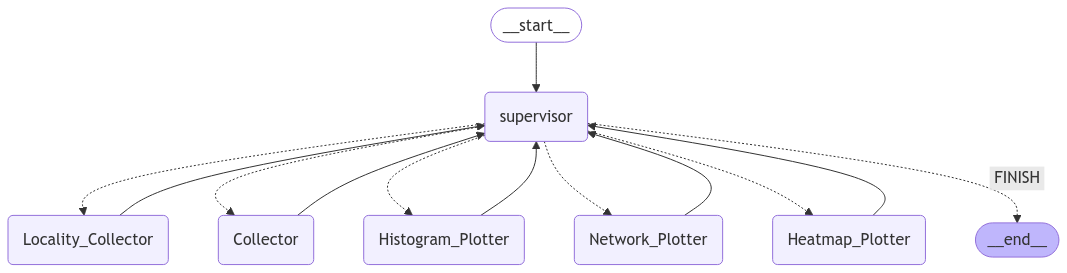

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

**Play with the workflow**

{'supervisor': {'next': 'Collector'}}
----
{'ima': True, 'hardness_min': 3.0, 'hardness_max': 5.0, 'crystal_system': ['Hexagonal'], 'elements_inc': 'Nd', 'elements_exc': 'S', 'page_size': 200}


Fetching data:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully saved 6 entries to /content/sample_data/geomaterials.json
{'Collector': {'messages': [HumanMessage(content='The dataset for the elements distribution of the specified IMA-approved mineral species has been collected and saved. You can find the file at the following path: `/content/sample_data/geomaterials.json`.', additional_kwargs={}, response_metadata={}, name='Collector')]}}
----
{'supervisor': {'next': 'Histogram_Plotter'}}
----


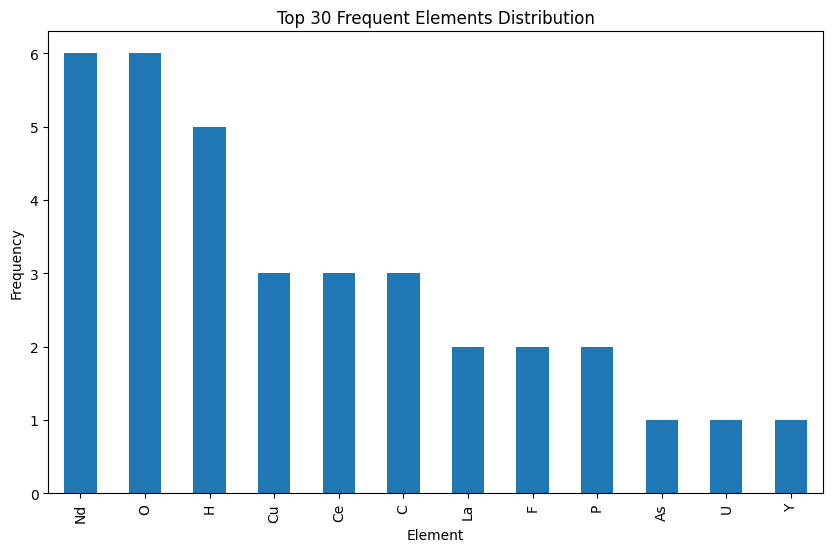

{'Histogram_Plotter': {'messages': [HumanMessage(content='I have finished plotting the histogram for the elements distribution of the specified mineral species. If you need further analysis or another visualization, feel free to ask!', additional_kwargs={}, response_metadata={}, name='Histogram_Plotter')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [25]:
# @title Query Complex Mineral Information and Plot Histogram for Element Distribution
# @markdown **Example Input:** plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur"

user_input = "plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur" # @param {type:"string"}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=user_input
            )
        ]
    }
):
    if "__end__" not in s:
        try:
            print(s)
            print("----")
        except:
            pass

In [25]:
# @title Plot Mineral Information in Network
# @markdown **Example Input:** Plot the network of the mineral distribution, which must have cobalt but not chlorine, in the Orthorhombic, Monoclinic, and Triclinic crystal system

user_input = "Plot the network of the mineral distribution, which must have cobalt but not chlorine, in the Orthorhombic, Monoclinic, and Triclinic crystal system" # @param {type:"string"}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=user_input
            )
        ]
    }
):
    if "__end__" not in s:
        try:
            print(s)
            print("----")
        except:
            pass

{'supervisor': {'next': 'Collector'}}
----
{'crystal_system': ['Orthorhombic', 'Monoclinic', 'Triclinic'], 'elements_inc': 'Co', 'elements_exc': 'Cl', 'expand': 'locality', 'page_size': 200}


Fetching data:   0%|          | 0/55 [00:00<?, ?it/s]

Successfully saved 55 entries to /content/sample_data/geomaterials.json
{'Collector': {'messages': [HumanMessage(content='The dataset has been successfully collected and saved. You can find the data at the following path: `/content/sample_data/geomaterials.json`.', additional_kwargs={}, response_metadata={}, name='Collector')]}}
----
{'supervisor': {'next': 'Network_Plotter'}}
----


{'Network_Plotter': {'messages': [HumanMessage(content='I have finished plotting the network of the mineral distribution with the specified parameters.', additional_kwargs={}, response_metadata={}, name='Network_Plotter')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [26]:
# @title Plot the Mineral Locality Heatmap for Countries
# @markdown **Example Input:** Plot the mineral heatmap for Brazil

# @markdown ❗ Please try using locality names from other countries and avoid plotting localities for the USA due to the excessive number of records, which may have caused workflow issues.
user_input = "Plot the mineral heatmap for Brazil" # @param {type:"string"}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=user_input
            )
        ]
    }
):
    if "__end__" not in s:
        try:
            print(s)
            print("----")
        except:
            pass

{'supervisor': {'next': 'Locality_Collector'}}
----
Brazil


Fetching data: 0it [00:00, ?it/s]

Successfully saved 2533 entries to /content/sample_data/mindat_locality.json
{'Locality_Collector': {'messages': [HumanMessage(content='The locality data for Brazil has been successfully collected and saved to the file path: `/content/sample_data/mindat_locality.json`. You can now proceed with plotting the mineral heatmap using this data.', additional_kwargs={}, response_metadata={}, name='Locality_Collector')]}}
----
{'supervisor': {'next': 'Heatmap_Plotter'}}
----


{'Heatmap_Plotter': {'messages': [HumanMessage(content='I have finished plotting the mineral heatmap for Brazil.', additional_kwargs={}, response_metadata={}, name='Heatmap_Plotter')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


### Step by step

In [ ]:
# @title Step by Step
# @markdown To see the step by step details, please try your input using this cell
user_input = "I want a heatmap for Canada" # @param {type:"string"}

import pprint
from langchain.schema import HumanMessage



# Run the workflow and detect __end__
events = graph.stream(
    {
        "messages": [HumanMessage(content=user_input)]
    },
    stream_mode="values",
)

for i, step in enumerate(events):
    print(f"Step {i}")
    print(type(step))
    pprint.pprint(dict(step), indent=2)

    # Iterate through keys and values in step
    for key, value in step.items():
        print(f"Key: {key}")
        print(f"Value: {value}")


Step 0
<class 'langgraph.pregel.io.AddableValuesDict'>
{'messages': [HumanMessage(content='I want a heatmap for Canada')]}
Key: messages
Value: [HumanMessage(content='I want a heatmap for Canada')]
Step 1
<class 'langgraph.pregel.io.AddableValuesDict'>
{ 'messages': [HumanMessage(content='I want a heatmap for Canada')],
  'next': 'Locality_Collector'}
Key: messages
Value: [HumanMessage(content='I want a heatmap for Canada')]
Key: next
Value: Locality_Collector
Canada


Fetching data: 0it [00:00, ?it/s]

Successfully saved 6737 entries to /content/sample_data/mindat_locality.json
Step 2
<class 'langgraph.pregel.io.AddableValuesDict'>
{ 'messages': [ HumanMessage(content='I want a heatmap for Canada'),
                HumanMessage(content='I have successfully collected the locality data for Canada. The data is saved in the file: `/content/sample_data/mindat_locality.json`.\n\nPlease proceed with the heatmap plotting using this file.', name='Locality_Collector')],
  'next': 'Locality_Collector'}
Key: messages
Value: [HumanMessage(content='I want a heatmap for Canada'), HumanMessage(content='I have successfully collected the locality data for Canada. The data is saved in the file: `/content/sample_data/mindat_locality.json`.\n\nPlease proceed with the heatmap plotting using this file.', name='Locality_Collector')]
Key: next
Value: Locality_Collector
Step 3
<class 'langgraph.pregel.io.AddableValuesDict'>
{ 'messages': [ HumanMessage(content='I want a heatmap for Canada'),
                H

Step 4
<class 'langgraph.pregel.io.AddableValuesDict'>
{ 'messages': [ HumanMessage(content='I want a heatmap for Canada'),
                HumanMessage(content='I have successfully collected the locality data for Canada. The data is saved in the file: `/content/sample_data/mindat_locality.json`.\n\nPlease proceed with the heatmap plotting using this file.', name='Locality_Collector'),
                HumanMessage(content='I have finished plotting the heatmap for Canada.', name='Heatmap_Plotter')],
  'next': 'Heatmap_Plotter'}
Key: messages
Value: [HumanMessage(content='I want a heatmap for Canada'), HumanMessage(content='I have successfully collected the locality data for Canada. The data is saved in the file: `/content/sample_data/mindat_locality.json`.\n\nPlease proceed with the heatmap plotting using this file.', name='Locality_Collector'), HumanMessage(content='I have finished plotting the heatmap for Canada.', name='Heatmap_Plotter')]
Key: next
Value: Heatmap_Plotter
Step 5
<clas